# Heat illnesses during European and World Championships in Athletics

Notebook that visualises the number of various heat-related illnesses against different daily heat indices based on the Universal Thermal Climate Index (UTCI).


Ignore this:

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 1. Load the data

In [3]:
# IMPORT PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

# read xlsx file
path = "/Users/milan/git/AthleticsChampionshipsHeat/data/"
# filename = "IllnessesHeat_10Sep.xlsx"
filename = "IllnessesHeat_Overview-perDay_22FEB2021.xlsx"
DF = pd.read_excel(path+filename)

# function to translate a column named by alphabet A,B,C,...AA,AB, etc into an index 1,2,3,...
def ABC2index(S):
    i=0
    for j,s in enumerate(list(S)):
        i += j*26+(ord(s)-65)
    
    return i

In [5]:
# LOAD HEAT ILLNESS DATA, various groupings
di_heatall = DF.values[:,ABC2index("AI")].astype(float)  # daily incidences ALL
di_heatexpl = DF.values[:,ABC2index("AJ")].astype(float)  # daily incidences ALL
di_heatendu = DF.values[:,ABC2index("AK")].astype(float)  # daily incidences ALL

# by discipline groups, short distance, etc. 
DF_disciplines = pd.read_excel(path+filename,sheet_name="Discipline-Epi")
di_heat_sd = DF_disciplines.values[:,ABC2index("T")].astype(float)  # short distance
di_heat_ce = DF_disciplines.values[:,ABC2index("U")].astype(float)  # combined events
di_heat_md = DF_disciplines.values[:,ABC2index("V")].astype(float)  # middle distance
di_heat_ld = DF_disciplines.values[:,ABC2index("W")].astype(float)  # long distance
di_heat_ma = DF_disciplines.values[:,ABC2index("X")].astype(float)  # marathon
di_heat_rw = DF_disciplines.values[:,ABC2index("Y")].astype(float)  # race walking

di_grouped = [di_heatall,di_heat_sd,di_heat_ce,
              di_heat_md,di_heat_ld,
              di_heat_ma,di_heat_rw]

In [8]:
# LOAD UTCI DATA
ndays = len(di_heatall)
UTCImax = np.zeros((ndays,3))    # time x (expected, min, max)
UTCImaxs = np.zeros((ndays,5,5))
UTCImean = np.zeros((ndays,3))
UTCI3day = np.zeros((ndays,3))
UTCIdiff = np.zeros((ndays,3))

events = ["berlin2009","daegu2011","helsinki2012", "moscow2013","zuerich2014",
          "amsterdam2016","berlin2018"]
events_long = ["Berlin 2009","Daegu 2011","Helsinki 2012","Moscow 2013","Zürich 2014",
        "Amsterdam 2016", "Berlin 2018"]
nevents = len(events)
ndays_per_event = [0,]*nevents

i = 0
for ifile,file in enumerate(events):
    # expected
    ma = np.load(path+"utci/"+file+"utci_daily.npz")["UTCI_dailymax"]
    me = np.load(path+"utci/"+file+"utci_daily.npz")["UTCI_dailymean"]
    td = np.load(path+"utci/"+file+"utci_daily.npz")["UTCI_3daymean"]
    di = np.load(path+"utci/"+file+"utci_daily.npz")["UTCI_dailydiff"]
    
    n = len(ma)
    ndays_per_event[ifile] = n
    
    UTCImax[i:i+n,0] = ma
    UTCImean[i:i+n,0] = me
    UTCI3day[i:i+n,0] = td
    UTCIdiff[i:i+n,0] = di
    
    # all
    UTCImaxs[i:i+n,:,:] = np.load(path+"utci/"+file+"utci_daily_maxs.npz")["UTCI_dailymaxs"]
    
    # uncertainty - minimum
    ma = np.load(path+"utci/"+file+"utci_daily.npz")["UTCI_dailymax0"]
    me = np.load(path+"utci/"+file+"utci_daily.npz")["UTCI_dailymean0"]
    td = np.load(path+"utci/"+file+"utci_daily.npz")["UTCI_3daymean0"]
    di = np.load(path+"utci/"+file+"utci_daily.npz")["UTCI_dailydiff0"]
    
    UTCImax[i:i+n,1] = ma
    UTCImean[i:i+n,1] = me
    UTCI3day[i:i+n,1] = td
    UTCIdiff[i:i+n,1] = di
    
    # uncertainty - maximum
    ma = np.load(path+"utci/"+file+"utci_daily.npz")["UTCI_dailymax1"]
    me = np.load(path+"utci/"+file+"utci_daily.npz")["UTCI_dailymean1"]
    td = np.load(path+"utci/"+file+"utci_daily.npz")["UTCI_3daymean1"]
    di = np.load(path+"utci/"+file+"utci_daily.npz")["UTCI_dailydiff1"]
    
    UTCImax[i:i+n,2] = ma
    UTCImean[i:i+n,2] = me
    UTCI3day[i:i+n,2] = td
    UTCIdiff[i:i+n,2] = di
    
    i += n

nidxs = np.concatenate([[0],np.cumsum(ndays_per_event)])

# sea points are 1e20, mask out
UTCImaxs = np.ma.masked_array(UTCImaxs,mask=UTCImaxs == 1e20)

In [9]:
fileout = open(path+"csv_new/UTCI_daily.csv","w")
fileout.write("Event, Day, UTCI daily max [˚C]\n")
for i in range(len(nidxs)-1):
    for day in range(nidxs[i],nidxs[i+1]):
        event_day = events_long[i]+", "+str(day+1-nidxs[i])+", "
        utci_str = str(UTCImax[day,0])
        fileout.write(event_day+utci_str+"\n")

fileout.close()

# 2. Linear/quadratic fit to data

1. Create UTCI bins, e.g. 4 or 5 ˚C
2. Sample randomly from the UTCI distribution for every event day (the uncertainty from location)
3. Put the data into the bins from 1.
4. Calculate the e.g. 10% risk of daily incidences
5. Statistically fit the 10% risk of daily incidences to bin-mids via linear/quadratic fit.
6. Repeat 1.-5. N times, as well as for the best-estimate (the central grid point, which is closest to the stadium).
7. Plot the best-estimate fit, as well as the 5-95% range of N fits.

In [10]:
# heat illness risk model, lin/quad with constraint that vertex has to be on x-axis.
def risk_lin(x,a,T0):
    return a*(x-T0)

def risk_quad(x,a,T0):
    return a*(x-T0)**2

# residual functions for least squares estimation
def residual_lin(p,x,y):
    return y-risk_lin(x,*p)

def residual_quad(p,x,y):
    return y-risk_quad(x,*p)

In [11]:
# least squares estimation
prisks = [10,50,"mean"]                # risk [%] of daily incidence considered
xall = np.linspace(10,40,100)          # evaluate models on these points

# uncertainty
mcn = 1000                                        # number of monte carlo draws
fits = np.empty((len(di_grouped),len(xall),mcn,len(prisks)))

slopes = np.empty((len(di_grouped),mcn,len(prisks)))               

for ip,prisk in enumerate(prisks):       # loop over different risk levels
    for n in range(mcn):                 # monte carlo mcn times
        UTCIrand = np.empty(ndays)       # pick random UTCI from grid points for each event day
        for ii in range(ndays):
            xy = np.random.randint(0,25)
            while UTCImaxs[ii,:,:].flatten().mask[xy]: # check that we don't pick a masked sea-point
                xy = np.random.randint(0,25)           # if masked, pull another random grid point

            UTCIrand[ii] = UTCImaxs[ii,:,:].flatten().data[xy]

        # pick bins based on sorting the temperatures
        npoints = np.random.randint(5,11)    # reasonable binsizes
        bins = np.sort(UTCIrand)[::npoints]
        bins[-1] = np.max(UTCIrand)          # extend last bin to be inclusive with max
        nbins = len(bins)-1                  # number of bins
        binmids = np.empty(nbins)            # bin centres

        for igroup,di_group in enumerate(di_grouped):
            di_perbin = np.empty(nbins)
        
            for i in range(nbins):
                which_utcis = np.logical_and(UTCIrand > bins[i],UTCIrand <= bins[i+1])
                ninbins = np.sum(which_utcis)

                # incidence rates have a 2std of +-1 error
                di_in_bin = di_group[which_utcis] + 0.5*np.random.randn(ninbins)

                # clip distributions at 0
                di_in_bin = np.maximum(di_in_bin,0)
                binmids[i] = np.mean(UTCIrand[which_utcis])

                if np.sum(which_utcis) == 0:
                    print(prisk,n,i,di_in_bin)

                if prisk == "mean":
                    di_perbin[i] = np.mean(di_in_bin)
                else:
                    di_perbin[i] = np.percentile(di_in_bin,100-prisk)

            # use either linear or quadratic model here
            p0 = [0.,15.]   # initial guess
            p_est = optimize.leastsq(residual_lin, p0, args=(binmids, di_perbin))[0]

            # store data in preallocated arrays
            slopes[igroup,n,ip] = p_est[0]
            fits[igroup,:,n,ip] = risk_lin(xall,*p_est)


/var/folders/13/7mnzvw3n197gtqtsw6nqn0s00000gn/T/ipykernel_11523/587515558.py:52: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  p_est = optimize.leastsq(residual_lin, p0, args=(binmids, di_perbin))[0]


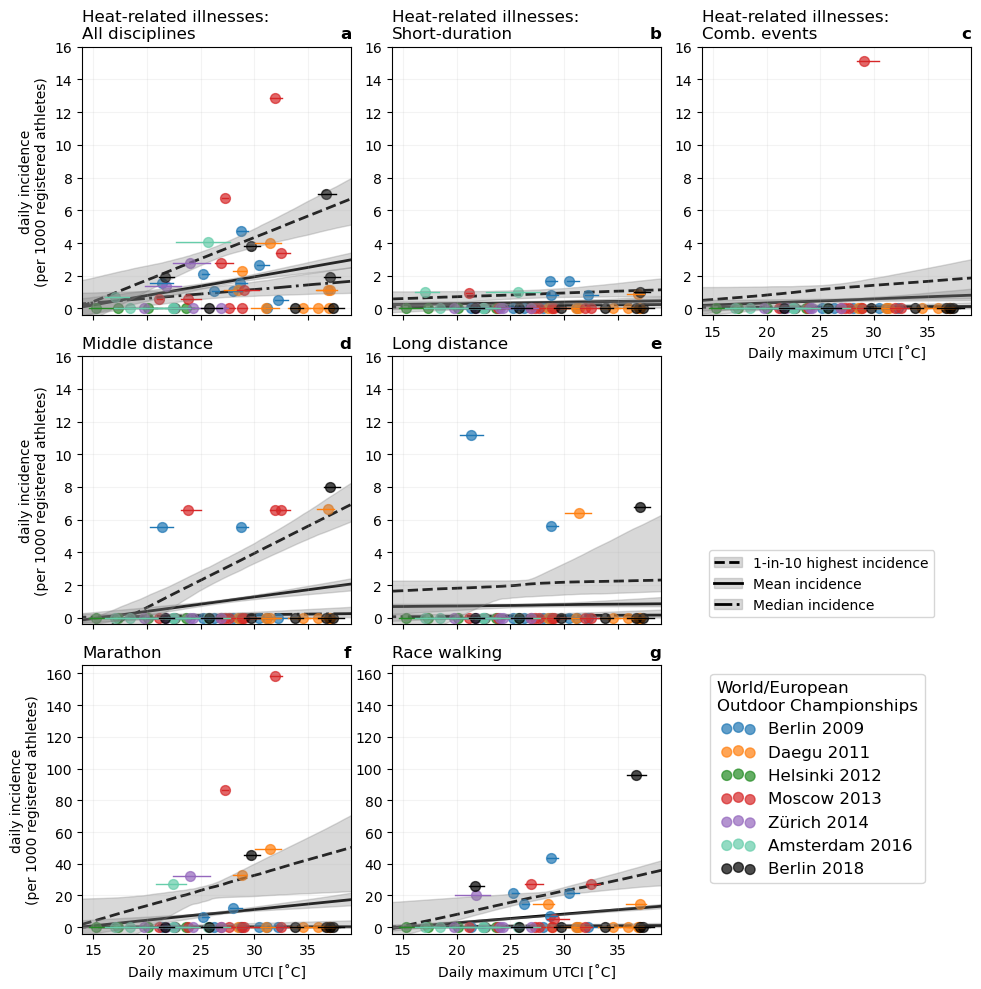

In [12]:
# PLOTTING
colours = ["C0","C1","forestgreen","C3","C4","mediumaquamarine","k"]

fig,axs = plt.subplots(3,3,figsize=(10,10))
alfa=0.7
alfa2=0.3
lws=1.0
pci = [2.5,97.5]

axv = [axs[0,0],axs[0,1],axs[0,2],axs[1,0],axs[1,1],axs[2,0],axs[2,1]]

# scatterpoints for expected
for i in range(nevents):
    j0,j1 = nidxs[i],nidxs[i+1]
    for igroup,di_group in enumerate(di_grouped):
        axv[igroup].scatter(UTCImax[j0:j1,0],di_group[j0:j1],50,color=colours[i],alpha=alfa,label=events_long[i])

# lines for uncertainty
for i in range(nevents):
    j0,j1 = nidxs[i],nidxs[i+1]
    for igroup,di_group in enumerate(di_grouped):
        axv[igroup].plot(UTCImax[j0:j1,1:].T,np.array([di_group[j0:j1]]*2),colours[i],lw=lws)

# curve fitting, subplot a
fb01 = axv[0].fill_between(xall,np.percentile(fits[0,:,:,0],pci[0],axis=1),np.percentile(fits[0,:,:,0],pci[1],axis=1),color="grey",alpha=alfa2)
fb02 = axv[0].fill_between(xall,np.percentile(fits[0,:,:,1],pci[0],axis=1),np.percentile(fits[0,:,:,1],pci[1],axis=1),color="grey",alpha=alfa2)
fb03 = axv[0].fill_between(xall,np.percentile(fits[0,:,:,2],pci[0],axis=1),np.percentile(fits[0,:,:,2],pci[1],axis=1),color="grey",alpha=alfa2)

h01, = axv[0].plot(xall,np.median(fits[0,:,:,0],axis=1),"k--",lw=2,zorder=-5)
h02, = axv[0].plot(xall,np.median(fits[0,:,:,1],axis=1),"k-.",lw=2,zorder=-5)
h03, = axv[0].plot(xall,np.median(fits[0,:,:,2],axis=1),"k",lw=2,zorder=-5)

axs[1,2].legend([(fb01,h01),(fb03,h03),(fb02,h02)],
             ("1-in-10 highest incidence","Mean incidence","Median incidence"),
              loc=3,fontsize=10)

for igroup,di_group in enumerate(di_grouped[1:]):
    igroup += 1
    axv[igroup].fill_between(xall,np.percentile(fits[igroup,:,:,0],pci[0],axis=1),np.percentile(fits[igroup,:,:,0],pci[1],axis=1),color="grey",alpha=alfa2)
    axv[igroup].fill_between(xall,np.percentile(fits[igroup,:,:,1],pci[0],axis=1),np.percentile(fits[igroup,:,:,1],pci[1],axis=1),color="grey",alpha=alfa2)
    axv[igroup].fill_between(xall,np.percentile(fits[igroup,:,:,2],pci[0],axis=1),np.percentile(fits[igroup,:,:,2],pci[1],axis=1),color="grey",alpha=alfa2)

    axv[igroup].plot(xall,np.median(fits[igroup,:,:,0],axis=1),"k--",lw=2,zorder=-5)
    axv[igroup].plot(xall,np.median(fits[igroup,:,:,1],axis=1),"k-.",lw=2,zorder=-5)
    axv[igroup].plot(xall,np.median(fits[igroup,:,:,2],axis=1),"k",lw=2,zorder=-5)

axv[0].set_title("Heat-related illnesses:\nAll disciplines",loc="left")
axv[1].set_title("Heat-related illnesses:\nShort-duration",loc="left")
axv[2].set_title("Heat-related illnesses:\nComb. events",loc="left")
axv[3].set_title("Middle distance",loc="left")
axv[4].set_title("Long distance",loc="left")
axv[5].set_title("Marathon",loc="left")
axv[6].set_title("Race walking",loc="left")

axs[1,2].axis("off")
axs[2,2].axis("off")

for i in range(len(di_grouped)):
    axv[i].set_title(chr(97+i),loc="right",fontweight="bold")
    axv[i].grid(alpha=.15)

axv[2].set_xlabel("Daily maximum UTCI [˚C]")
axv[-2].set_xlabel("Daily maximum UTCI [˚C]")
axv[-1].set_xlabel("Daily maximum UTCI [˚C]")

axs[0,0].set_ylabel("daily incidence\n(per 1000 registered athletes)")
axs[1,0].set_ylabel("daily incidence\n(per 1000 registered athletes)")
axs[2,0].set_ylabel("daily incidence\n(per 1000 registered athletes)")

# plot just for legend
for i in range(nevents):
    axs[2,2].scatter([0],[0],50,color=colours[i],alpha=alfa,label=events_long[i])

axs[2,2].legend(loc=2,fontsize=12,title_fontsize=12,
              scatterpoints=3,title="World/European\nOutdoor Championships")
axs[2,2].set_xlim(14,39)

axv[0].set_ylim(0,16)
axv[1].set_ylim(0,16)
axv[2].set_ylim(0,16)
axv[3].set_ylim(0,16)
axv[4].set_ylim(0,16)
axv[5].set_ylim(0,165)
axv[6].set_ylim(0,165)

for ax in axv:
    ax.set_xlim(14,39)

for ax in [axv[0],axv[1],axv[3],axv[4]]:
    ax.set_xticklabels([])
    
for i in range(len(di_grouped)):
    prev_ymax = axv[i].get_ylim()[1]
    axv[i].set_ylim(-prev_ymax/40,prev_ymax)

plt.tight_layout(w_pad=0,h_pad=-0.3)
plt.savefig("../plots/new/heatillness_utci.png")
plt.savefig("../plots/new/heatillness_utci.pdf")

In [25]:
axv[5].get_xticklabels()[0]

Text(10.0, 0, '')

### SLOPES, all disciplines

In [13]:
# mean incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,2,0]),np.percentile(slopes[:,2,0],2.5),np.percentile(slopes[:,2,0],97.5)]
print("All disciplines")
print("Slope for mean incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

All disciplines
Slope for mean incidences: 0.37±0.50 incidence rate/˚C


In [14]:
# mean incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,1,0]),np.percentile(slopes[:,1,0],2.5),np.percentile(slopes[:,1,0],97.5)]
print("All disciplines")
print("Slope for median incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

All disciplines
Slope for median incidences: 0.63±1.11 incidence rate/˚C


In [15]:
# 10%risk incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,0,0]),np.percentile(slopes[:,0,0],2.5),np.percentile(slopes[:,0,0],97.5)]
print("All disciplines")
print("Slope for 10%-risk incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

All disciplines
Slope for 10%-risk incidences: 0.66±1.22 incidence rate/˚C


### SLOPES, explosive only

In [12]:
# mean incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,2,1]),np.percentile(slopes[:,2,1],2.5),np.percentile(slopes[:,2,1],97.5)]
print("Heat illnesses")
print("Slope for mean incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

Heat illnesses
Slope for mean incidences: 0.02±0.04 incidence rate/˚C


In [13]:
# mean incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,1,1]),np.percentile(slopes[:,1,1],2.5),np.percentile(slopes[:,1,1],97.5)]
print("Heat illnesses")
print("Slope for median incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

Heat illnesses
Slope for median incidences: 0.02±0.03 incidence rate/˚C


In [14]:
# 10%risk incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,0,1]),np.percentile(slopes[:,0,1],2.5),np.percentile(slopes[:,0,1],97.5)]
print("Heat illnesses")
print("Slope for 10%-risk incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

Heat illnesses
Slope for 10%-risk incidences: 0.02±0.02 incidence rate/˚C


### SLOPES, endurance only

In [15]:
# mean incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,2,2]),np.percentile(slopes[:,2,2],2.5),np.percentile(slopes[:,2,2],97.5)]
print("Heat illnesses")
print("Slope for mean incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

Heat illnesses
Slope for mean incidences: 0.23±0.41 incidence rate/˚C


In [16]:
# mean incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,1,2]),np.percentile(slopes[:,1,2],2.5),np.percentile(slopes[:,1,2],97.5)]
print("Heat illnesses")
print("Slope for median incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

Heat illnesses
Slope for median incidences: 0.24±0.38 incidence rate/˚C


In [17]:
# mean incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,0,2]),np.percentile(slopes[:,0,2],2.5),np.percentile(slopes[:,0,2],97.5)]
print("Heat illnesses")
print("Slope for 1-in-10 incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

Heat illnesses
Slope for 1-in-10 incidences: 0.17±0.25 incidence rate/˚C


## Distributions per temperature category

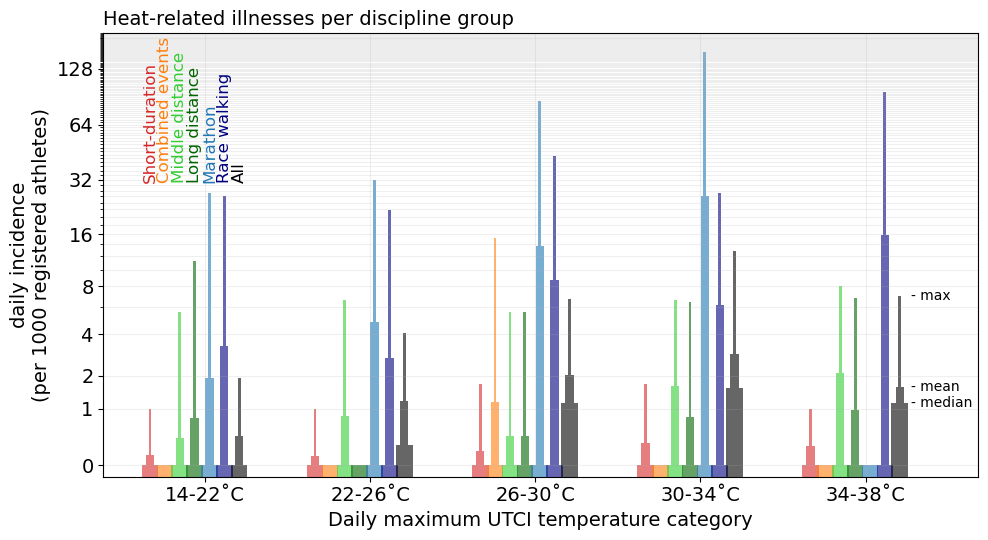

In [16]:
temp_categories = [14,22,26,30,34,38]

# resort for this plot
di_grouped = [di_heat_sd,di_heat_ce,di_heat_md,di_heat_ld,
              di_heat_ma,di_heat_rw,di_heatall]

xshift_categ = 1
xshift_group = 0.09
width = 0.1
alfa = 0.6
yd = 0.2
yshift = 0.05

groupcolours = ["C3","C1","limegreen","darkgreen","C0","navy","k"]
grouplabels = ["Short-duration","Combined events","Middle distance","Long distance",
                "Marathon","Race walking","All"]

fig,ax = plt.subplots(figsize=(10,5.5))

for it in range(len(temp_categories)-1):
    days_in_temprange = np.logical_and(UTCImax[:,1] > temp_categories[it],
                                       UTCImax[:,1] <= temp_categories[it+1])
    for igroup,di_group in enumerate(di_grouped):
        di_median = np.log2(1+np.median(di_group[days_in_temprange]))
        di_mean   = np.log2(1+np.mean(di_group[days_in_temprange]))
        di_90p    = np.log2(1+np.percentile(di_group[days_in_temprange],90))
        di_max    = np.log2(1+np.max(di_group[days_in_temprange]))
        
        xpos = it*xshift_categ+xshift_group*igroup
        ax.bar(xpos,yd+di_median,width=width,alpha=alfa,bottom=-yd,color=groupcolours[igroup])
        ax.bar(xpos,di_mean-di_median,bottom=di_median,color=groupcolours[igroup],width=width/2,alpha=alfa)
        ax.bar(xpos,di_max-di_mean,bottom=di_mean,color=groupcolours[igroup],width=width/6,alpha=alfa)
        
        if it == 0:
            ax.text(xpos,np.log2(1+32),grouplabels[igroup],
                    color=groupcolours[igroup],rotation=90,fontsize=12,ha="center")
        
        if it == len(temp_categories)-2:
            if igroup == len(di_grouped)-1:
                ax.text(xpos*1.015,di_median,"- median",va="center")
                ax.text(xpos*1.015,di_mean,"- mean",va="center")
                ax.text(xpos*1.015,di_max,"- max",va="center")

ytikm = np.arange(0,200,2)
ytiks = np.array([0,1,2,4,8,16,32,64,128])
ax.set_ylim(-yd,np.log2(1+np.max(ytikm)))
ax.set_yticks(np.log2(1+ytikm),minor=True)
ax.set_yticks(np.log2(1+ytiks))
ax.set_yticklabels(ytiks,fontsize=14)
ax.grid(which="both",alpha=0.2)
ax.set_xticks(xshift_categ/3 + np.array(range(len(temp_categories)-1)))
ax.set_xticklabels(["14-22˚C","22-26˚C","26-30˚C","30-34˚C","34-38˚C"],fontsize=14)
ax.set_xlabel("Daily maximum UTCI temperature category",fontsize=14)
ax.set_ylabel("daily incidence\n(per 1000 registered athletes)",fontsize=14)
ax.set_title("Heat-related illnesses per discipline group",loc="left",fontsize=14)

ax.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1]*1.04)

plt.tight_layout()
plt.savefig("../plots/new/heatgroup_log.png")
plt.savefig("../plots/new/heatgroup_log.pdf")

In [20]:
fileout = open(path+"csv_new/fig3.csv","w")
fileout.write("UTCI range min [˚C], UTCI range max [˚C], discipline, daily incidence median, daily incidence mean, daily incidence max\n")

for it in range(len(temp_categories)-1):
    days_in_temprange = np.logical_and(UTCImax[:,1] > temp_categories[it],
                                       UTCImax[:,1] <= temp_categories[it+1])
    for igroup,di_group in enumerate(di_grouped):
        di_median = np.median(di_group[days_in_temprange])
        di_mean   = np.mean(di_group[days_in_temprange])
        di_max    = np.max(di_group[days_in_temprange])

        s = ",".join([str(temp_categories[it]),
                  str(temp_categories[it+1])
                  grouplabels[igroup],
                  "{:.4f}".format(di_median),
                  "{:.4f}".format(di_mean),
                  "{:.4f}".format(di_max)])
        fileout.write(s+"\n")

fileout.close()

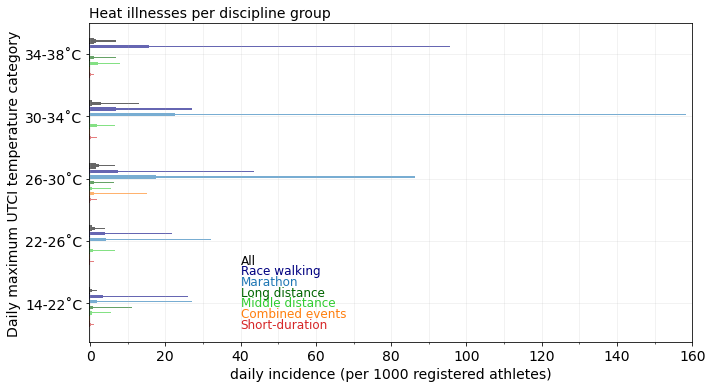

In [109]:
temp_categories = [14,22,26,30,34,38]

# resort for this plot
di_grouped = [di_heat_sd,di_heat_ce,di_heat_md,di_heat_ld,
              di_heat_ma,di_heat_rw,di_heatall]

yshift_categ = 1
yshift_group = 0.09
height = 0.1
alfa = 0.6
xd = 0.2

groupcolours = ["C3","C1","limegreen","darkgreen","C0","navy","k"]
grouplabels = ["Short-duration","Combined events","Middle distance","Long distance",
                "Marathon","Race walking","All"]

fig,ax = plt.subplots(figsize=(10,5.5))

for it in range(len(temp_categories)-1):
    days_in_temprange = np.logical_and(UTCImax[:,1] > temp_categories[it],
                                       UTCImax[:,1] <= temp_categories[it+1])
    for igroup,di_group in enumerate(di_grouped):
        di_median = np.median(di_group[days_in_temprange])
        di_mean   = np.mean(di_group[days_in_temprange])
        di_90p    = np.percentile(di_group[days_in_temprange],90)
        di_max    = np.max(di_group[days_in_temprange])
        
        ypos = it*yshift_categ+yshift_group*igroup
        ax.barh(ypos,xd+di_median,height=width,alpha=alfa,left=-xd,color=groupcolours[igroup])
        ax.barh(ypos,di_mean-di_median,left=di_median,color=groupcolours[igroup],height=height/2,alpha=alfa)
        ax.barh(ypos,di_max-di_mean,left=di_mean,color=groupcolours[igroup],height=height/6,alpha=alfa)
        
        if it == 0:
            ax.text(40,ypos*1.9,grouplabels[igroup],
                    color=groupcolours[igroup],fontsize=12,va="center")
        
#         if it == len(temp_categories)-2:
#             if igroup == len(di_grouped)-1:
#                 ax.text(xpos*1.015,di_median,"- median",va="center")
#                 ax.text(xpos*1.015,di_mean,"- mean",va="center")
#                 ax.text(xpos*1.015,di_max,"- max",va="center")

xtikm = np.arange(0,170,10)
xtiks = np.array([0,20,40,60,80,100,120,140,160])
ax.set_xlim(-yd,np.max(xtikm))
ax.set_xticks(xtikm,minor=True)
ax.set_xticks(xtiks)
ax.set_xticklabels(xtiks,fontsize=14)
ax.grid(which="both",alpha=0.2)
ax.set_yticks(yshift_categ/3 + np.array(range(len(temp_categories)-1)))
ax.set_yticklabels(["14-22˚C","22-26˚C","26-30˚C","30-34˚C","34-38˚C"],fontsize=14)
ax.set_ylabel("Daily maximum UTCI temperature category",fontsize=14)
ax.set_xlabel("daily incidence (per 1000 registered athletes)",fontsize=14)
ax.set_title("Heat illnesses per discipline group",loc="left",fontsize=14)

plt.tight_layout()
plt.savefig("../plots/heatgroup_lin.png")

In [44]:
?plt.barh